# COVID 19 Severity Prediction  
**Goal**: For a given individual who is diagnosed with COVID 19 we want to determine the severity of their infection in terms of the probability of decease and probability of ICU admittance.  
**Dataset**: The dataset available to us is curated by the Mexico Government and contains information for 500k+ observations. It contains information regarding the result of the test, time of detection, demographic information and most importantly that of various health conditions.  

## Data Preparation

In [259]:
import pandas as pd
import numpy as np

In [260]:
# Import and asses dataset
# Dataset description can be found at: https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset?select=covid.csv
df = pd.read_csv("../data/mexico_government_covid19_patient/covid.csv")
print(df.shape)
df.head()

(566602, 23)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


If the date_died is invalid then the given case of COVID 19 did not result in fatality. So we form a new feature "lethal" indicating this. All invalid dates are replaced with no(2), and all valid dates are replaced with 1(yes).

In [261]:
# Change the data died column to indicate if patient death
# If there is a valid date then patient death and represent as 1 otherwise represent as 2
df['date_died'] = df['date_died'].replace(to_replace="9999-99-99", value=2)
df['date_died'] = df['date_died'].mask(df['date_died'].ne(2), 1)
df = df.rename(columns={'date_died':'lethal'})
df.head()

,id,sex,patient_type,entry_date,date_symptoms,lethal,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,2,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,2,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,2,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,2,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


The features entry_date and date_symptoms provide valuable information, but by themselves they are not relevant to determining the severity of COVID 19. A more relevant feature would be the time between entry_date and data_symptoms. So we create a feature by subtracting these two values.

In [262]:
# With date_symptoms and entry_date we can calculate time between disease contraction and medical attention
# This would be a more relevant feature to use rather than just the dates
df['days_to_medical_help'] = (pd.to_datetime(df['entry_date'], dayfirst=True) - pd.to_datetime(df['date_symptoms'], dayfirst=True)).dt.days
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,id,sex,patient_type,lethal,intubed,pneumonia,age,pregnancy,diabetes,copd,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,days_to_medical_help
0,16169f,2,1,2,97,2,27,97,2,2,...,2,2,2,2,2,2,2,1,97,2
1,1009bf,2,1,2,97,2,24,97,2,2,...,2,2,2,2,2,2,99,1,97,2
2,167386,1,2,2,2,2,54,2,2,2,...,2,2,2,1,2,2,99,1,2,5
3,0b5948,2,2,2,2,1,30,97,2,2,...,2,2,2,2,2,2,99,1,2,7
4,0d01b5,1,2,1,2,2,60,2,1,2,...,1,2,1,2,2,2,99,1,2,0


In [263]:
# Drop Patient ID from the dataset since it won't help in predictions
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

In [264]:
# Check data types of all features
df.dtypes

sex                      int64
patient_type             int64
lethal                  object
intubed                  int64
pneumonia                int64
age                      int64
pregnancy                int64
diabetes                 int64
copd                     int64
asthma                   int64
inmsupr                  int64
hypertension             int64
other_disease            int64
cardiovascular           int64
obesity                  int64
renal_chronic            int64
tobacco                  int64
contact_other_covid      int64
covid_res                int64
icu                      int64
days_to_medical_help     int64
dtype: object

Now even though we know that most of these variables are categorical pandas has encoded them as int or floats so we must convert them to categorical. We also would want to normalize all non-categorical variables and replace missing values encoded as 97, 98, and 99 in the categorical variable. We also change the encoding from 2 -> No to 0 -> to No.

In [265]:
# Since most categorical features are currently int64 change them to categorical
# We also want to normalize all non categorical features
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
categorical_columns = ['sex', 'patient_type',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'lethal']
# The dataset indicates that missing values are 97, 98, 99 so we replace them with -1 for uniformity
scalers = {}
for column in df.columns:
    if column in categorical_columns:
        # Change no encoding from 2 to 0
        df[column] = df[column].replace(to_replace=2, value=0)
        # Replace all missing values with -1
        df[column] = df[column].replace(to_replace=[97, 98, 99], value=-1).astype('category')
    else:
        # Normalize non categorical features
        scalers[column] = MinMaxScaler().fit(np.array(df[column]).reshape(-1, 1))
        df[column] = scalers[column].transform(np.array(df[column]).reshape(-1, 1))[:, 0]
        dump(scalers[column], str(column) + '_scaler.joblib') 

In [266]:
# Now we can only use observations in which the individual tested postive for COVID 19
covid_cases = df[df['covid_res'] == 1]
covid_cases.shape

(220657, 21)

In [267]:
# Encoding of 3 for 'covid_res' is supposed to be awaiting results so we can use these as the prediction set for risk assesment
awaiting_cases = df[df['covid_res'] == 3]
awaiting_cases.shape

(66910, 21)

In [268]:
# Variables to store the outcomes and features
# We could try combining icu and death
# However we do not want to include either in the prediction for the other due to expected high dependency
"""features = ['sex', 'patient_type', 'age', 'days_to_medical_help',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']"""
features = ['sex', 'age', 'days_to_medical_help', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']
outcomes = ['icu', 'death']

## ICU Predictions

In [269]:
# First we train a model to predict 'icu' for that we form a dataset of known icu cases i.e Yes or No so we remove 0s which were
# supposed to be missing values or cases in which we do not know if the individual was in the icu
current_outcome = outcomes[0] # i.e 'icu'
icu_res_known = covid_cases[covid_cases['icu'] != -1]
icu_res_known.shape

(68210, 21)

In [270]:
# Split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])

<AxesSubplot:xlabel='icu', ylabel='count'>

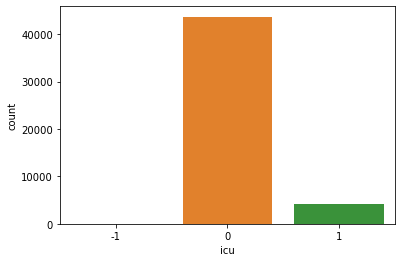

In [271]:
# Before we train we want to check the distribution of icu in the train set to ensure proper training
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='icu', data=train)

In [272]:
# The above graph indicates that the data is highly biased so we must perform some sampling to balance the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Over Sample the Minority Label to be 0.3 in proportion
over = SMOTE(sampling_strategy=0.3)
# Down Sample the Majority Label so that there are twice as many as minority
under = RandomUnderSampler(sampling_strategy=0.5)
# Pipeline to combine 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Sampled data
obs, results = pipeline.fit_resample(train[features], train['icu'])
obs = obs.fillna(0)

In [273]:
# Check if sampling has given the desired results
len(results[results == 0]), len(results[results == 1])

(26202, 13101)

In [274]:
# Only down sample the "no" icu observations
icu_yes = train[train['icu'] == 1]
icu_no = train[train['icu'] == 0]
new_train = icu_yes.append(icu_no.sample(icu_yes.shape[0]))

**SMOTE Random Forest**

In [275]:
# Train Random Forest as a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
rf = RandomForestClassifier(n_estimators=20).fit(obs, results)
print("Accuracy: {}".format(rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8809558715730831
Precision: [0.9441292  0.33864169]
Recall: [0.92455653 0.41385232]
F-Score: [0.93424036 0.37248841]


In [276]:
# Train Random Forest as a baseline model
down_rf = RandomForestClassifier(n_estimators=100).fit(new_train[features], new_train['icu'])
print("Accuracy: {}".format(down_rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], down_rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.73019596344622
Precision: [0.96107345 0.19337017]
Recall: [0.73477239 0.68116772]
F-Score: [0.83282362 0.30122769]


**Normal Data Random Forest**

In [277]:
# Let us test for the non sampled dataset
rf_normal = RandomForestClassifier(n_estimators=10, max_depth=10).fit(train[features], train['icu'])
print("Accuracy: {}".format(rf_normal.score(test[features], test['icu'])))
metrics_normal = precision_recall_fscore_support(test['icu'], rf_normal.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics_normal[0], metrics_normal[1], metrics_normal[2]))

Accuracy: 0.9179006010848849
Precision: [0.92985466 0.55177743]
Recall: [0.98450524 0.20435031]
F-Score: [0.95639988 0.29824561]


**SMOTE & Training Functions**

In [278]:
# Lets repeat the procedure for "death" risk prediciton but with a function since that might help with the API implementation
def checkBinaryBalance(data, features, output, negative_label=0, positive_label=1):
    data_arr = np.array(data[output])
    if abs(data_arr[data_arr == negative_label]. shape[0] / len(data) - data_arr[data_arr == positive_label].shape[0] / len(data_arr)) > 0.4:
        print("Not Balanced returning sampled dataet.")
        # Over Sample the Minority Label to be 0.3 in proportion
        over = SMOTE(sampling_strategy=0.3)
        # Down Sample the Majority Label so that there are twice as many as minority
        under = RandomUnderSampler(sampling_strategy=0.5)
        # Pipeline to combine 
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # Sampled data
        obs, results = pipeline.fit_resample(data[features], data_arr)
        obs = obs.fillna(0)
        return obs, results
    print("Balanced dataset returning original.")
    obs = data[features]
    results = data_arr
    return obs, results

def randomForestEvaluation(obs, results, test_obs, test_results):
    rf = RandomForestClassifier(n_estimators=40, max_depth=10).fit(obs, results)
    print("Accuracy: {}".format(rf.score(test_obs, test_results)))
    metrics = precision_recall_fscore_support(test_results, rf.predict(test_obs))
    print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

**All sklearn-models**

In [279]:
# Now that we have trained on Random Forest Let us test the baselines for all classifiers within the sklearn library
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    #KNeighborsClassifier(2),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=20),
    MLPClassifier(max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
]

"""names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]"""
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

def allModelEvaluation(names, classifiers, obs, results, test_obs, test_results):
    scores = {}
    for name, clf in zip(names, classifiers):
        print("Training " + name)
        clf.fit(obs, results)
        train_score =  clf.score(obs, results)
        metrics_train = precision_recall_fscore_support(results, clf.predict(obs))
        test_score = clf.score(test_obs, test_results)
        metrics_test = precision_recall_fscore_support(test_results, clf.predict(test_obs))
        print("Train Accuracy: {}".format(train_score))
        print("Train Precision: {}\nTrain Recall: {}\nTrain F-Score: {}\n".format(metrics_train[0], metrics_train[1], metrics_train[2]))
        print("Test Accuracy: {}".format(test_score))
        print("Test Precision: {}\nTest Recall: {}\nTest F-Score: {}".format(metrics_test[0], metrics_test[1], metrics_test[2]))
        scores[name] = {'test accuracy' : test_score, 'test precision' : metrics_test[0], 'test recall': metrics_test[1], 'train accuracy' : train_score, 'train precision' : metrics_train[0], 'train recall' : metrics_train[1]}
        print("-----------")
    return scores

In [280]:
# Evaluate all models for "icu"
# Form train test
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)
sampled_icu_scores = allModelEvaluation(names, classifiers, new_train[features], new_train['icu'], test[features], test['icu'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9577914110429447
Train Precision: [0.93172877 0.98720293]
Train Recall: [0.98797546 0.92760736]
Train F-Score: [0.95902811 0.95647773]

Test Accuracy: 0.7121145482089625
Test Precision: [0.97893793 0.20709641]
Test Recall: [0.7003099  0.83858042]
Test F-Score: [0.81650833 0.33216189]
-----------
Training Random Forest
Train Accuracy: 0.9505521472392638
Train Precision: [0.94390716 0.9573991 ]
Train Recall: [0.95803681 0.94306748]
Train F-Score: [0.9509195  0.95017926]

Test Accuracy: 0.7598103894834579
Test Precision: [0.98245123 0.24285714]
Test Recall: [0.75080145 0.85632513]
Test F-Score: [0.85114631 0.37839889]
-----------
Training Neural Net
Train Accuracy: 0.7685889570552147
Train Precision: [0.70530857 0.88825825]
Train Recall: [0.92269939 0.61447853]
Train F-Score: [0.79948969 0.72642878]

Test Accuracy: 0.8788056492205444
Test Precision: [0.96098807 0.37153873]
Test Recall: [0.90419962 0.60675444]


**Hyper-parameter Optimization**

In [21]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'icu_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8879929629086645
Precision: [0.94683861 0.36930456]
Recall: [0.92973926 0.44075558]
F-Score: [0.93821103 0.40187891]


In [281]:
# Hyper-parameter tuning based on custom scorer (accuracy, precision, or recall) and leveraging K-Fold startification for Grid 
# Search on Validation and Training Set
# Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [1, 3, 5, 10, 15, 20], 
    'n_estimators' : [20, 50, 100, 150, 200],
    'max_depth': [3, 5, 15, 25, 30],
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(new_train[features], new_train['icu'])

    # make the predictions
    y_pred = grid_search.predict(test[features].values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test['icu'], y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Not Balanced returning sampled dataet.
Best params for recall_score
{'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 200}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     14305      4411
pos       256      1491


In [282]:
print("Accuracy: {}".format(grid_search_clf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], grid_search_clf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8534630795649685
Precision: [0.98241879 0.25262623]
Recall: [0.7643193  0.85346308]
F-Score: [0.85975298 0.38985488]


In [283]:
# Train using recommended parameters
temp_rf = RandomForestClassifier(n_estimators=100, min_samples_split=3, max_depth=30).fit(new_train[features], new_train['icu'])
print("Accuracy: {}".format(temp_rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], temp_rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.7740311782241118
Precision: [0.98134991 0.25304721]
Recall: [0.76752511 0.84373211]
F-Score: [0.86136595 0.38932911]


In [284]:
# Save Model
dump(temp_rf, 'recall_optimized_rf.joblib')

['recall_optimized_rf.joblib']

**Keras Fully-connected**

In [285]:
# Let us now train on a Dense Model in Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)

Not Balanced returning sampled dataet.


In [286]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=len(features)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
____________________________________________________

In [287]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("icu.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [288]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['icu'], test_size=0.5, shuffle=True, stratify=test['icu'])

In [289]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100
1206/1229 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.8003
Epoch 00001: val_accuracy improved from -inf to 0.91067, saving model to icu_new.h5
1229/1229 [==============================] - 3s 2ms/step - loss: 0.4922 - accuracy: 0.8003 - val_loss: 0.3595 - val_accuracy: 0.9107
Epoch 2/100
1216/1229 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.8119
Epoch 00002: val_accuracy improved from 0.91067 to 0.91077, saving model to icu_new.h5
1229/1229 [==============================] - 2s 1ms/step - loss: 0.4751 - accuracy: 0.8122 - val_loss: 0.3310 - val_accuracy: 0.9108
Epoch 3/100
1222/1229 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.8124
Epoch 00003: val_accuracy improved from 0.91077 to 0.91087, saving model to icu_new.h5
1229/1229 [==============================] - 1s 1ms/step - loss: 0.4720 - accuracy: 0.8124 - val_loss: 0.3509 - val_accuracy: 0.9109
Epoch 4/100
1223/1229 [=======================

Epoch 00028: early stopping


In [290]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("icu.h5") 
model.evaluate(test[features], test['icu'])

640/640 [==============================] - 0s 503us/step - loss: 0.3077 - accuracy: 0.9125


[0.3076624870300293, 0.9125250577926636]

In [291]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

320/320 [==============================] - 0s 484us/step - loss: 0.3062 - accuracy: 0.9136


[0.30622386932373047, 0.9135959148406982]

In [292]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test['icu'], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95637403 0.48879625]
Recall: [0.94758495 0.53692044]
F-Score: [0.95195921 0.51172941]


In [293]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95795504 0.49438202]
Recall: [0.94710408 0.55441008]
F-Score: [0.95249866 0.52267819]


## Lethality Predictions

In [294]:
# Form dataset with only death status known
lethal_res_known = covid_cases[covid_cases['lethal'] != -1]
lethal_res_known.shape

(220657, 21)

In [295]:
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])

In [296]:
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)

Not Balanced returning sampled dataet.


**Random Forest Evaluation**

In [297]:
# Evaluate Random Forest on training from the sampled dataset
randomForestEvaluation(obs, results, test[features], test['lethal'])

Accuracy: 0.8442400072509744
Precision: [0.97595838 0.43217961]
Recall: [0.84318487 0.85176991]
F-Score: [0.90472626 0.57341442]


In [298]:
# Evaluate Rnadom forest on training form the original dataset
randomForestEvaluation(train[features], train['lethal'], test[features], test['lethal'])

Accuracy: 0.8953593764162059
Precision: [0.91408211 0.63575118]
Recall: [0.97206435 0.34795969]
F-Score: [0.94218201 0.44975772]


In [299]:
# Evaluate all models for "lethal"
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)
sampled_lethal_scores = allModelEvaluation(names, classifiers, obs, results, test[features], test['lethal'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9521677082820728
Train Precision: [0.95539702 0.94532289]
Train Recall: [0.97370946 0.9090842 ]
Train F-Score: [0.96446632 0.92684946]

Test Accuracy: 0.8544366899302094
Test Precision: [0.92988779 0.42404294]
Test Recall: [0.90205298 0.51462635]
Test F-Score: [0.91575892 0.46496391]
-----------
Training Random Forest
Train Accuracy: 0.9508472352082411
Train Precision: [0.96590389 0.92126444]
Train Recall: [0.96016436 0.93221298]
Train F-Score: [0.96302557 0.92670637]

Test Accuracy: 0.8564458140729327
Test Precision: [0.94187126 0.43924984]
Test Recall: [0.89134029 0.6074238 ]
Test F-Score: [0.91590935 0.50982617]
-----------
Training Neural Net
Train Accuracy: 0.8503190459787084
Train Precision: [0.91824141 0.74041228]
Train Recall: [0.85127454 0.84840805]
Train F-Score: [0.88349081 0.79073981]

Test Accuracy: 0.8471403969908456
Test Precision: [0.97194495 0.43563778]
Test Recall: [0.85026351 0.82485251]


In [43]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'lethal_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['lethal'])))
metrics = precision_recall_fscore_support(test['lethal'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8627602042357775
Precision: [0.95673014 0.4622844 ]
Recall: [0.88348662 0.71484759]
F-Score: [0.91865078 0.56147126]


In [300]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=17))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                1152      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
___________________________________________________

In [301]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("lethal.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [302]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['lethal'], test_size=0.5, shuffle=True, stratify=test['lethal'])

In [303]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100


ValueError: in user code:

    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\soumi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: expected axis -1 of input shape to have value 17 but received input with shape [None, 16]


In [ ]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("lethal.h5") 
model.evaluate(test[features], test["lethal"])

In [ ]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

In [ ]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test["lethal"], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

In [ ]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))